# 라이브러리 호출

In [1]:
import os, tqdm, math, random, argparse

import numpy as np
import pandas as pd

from glob import glob
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

import segmentation_models_pytorch as smp
from pytorch_msssim import MS_SSIM
from collections import Counter



In [2]:
print(torch.__version__)

1.7.1


In [3]:
import gc
gc.collect()
torch.cuda.empty_cache()

#학습은 gpu환경에서 실행한다.
#이미지,모델을 gpu메모리에 넣어야 하는데 그 전에 gpu 메모리를 초기화 시켜주는 코드

# 장치설정

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

#device는 학습 환경을 cpu로 할 것인지 아니면 gpu로 할것인지 에 대한 변수이다.
# torch.cuda.is_available()는 말 그대로 cuda(gpu)을 사용할 수 있으면 사용하겠다는 의미

cuda:0


In [5]:
!nvidia-smi

#현재 내가 사용할 수 있는 gpu와 그에 대한 상태를 표시

Mon Feb 21 01:28:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.09       Driver Version: 497.09       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 41%   53C    P0    34W / 160W |   1046MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# csv파일 열기

In [6]:
train_csv = pd.read_csv('C:/Users/User/Desktop/train.csv')
test_csv = pd.read_csv('C:/Users/User/Desktop/test.csv')

#pd 는 pandas 라이브러리의 약자로 엑셀 파일등을 읽어오는 데 주로 사용한다
#pd.read_csv는 csv파일을 읽기모드로 열겠다는 소리

In [7]:
train_csv.head()
#train_csv의 머리말을 출력

,img_id,input_img,label_img
0,10000,train_input_10000.png,train_label_10000.png
1,10001,train_input_10001.png,train_label_10001.png
2,10002,train_input_10002.png,train_label_10002.png
3,10003,train_input_10003.png,train_label_10003.png
4,10004,train_input_10004.png,train_label_10004.png


In [8]:
test_csv.head()
#test_csv의 머리말을 출력

,img_id,input_img,submission_name
0,20000,test_input_20000.png,test_20000.png
1,20001,test_input_20001.png,test_20001.png
2,20002,test_input_20002.png,test_20002.png
3,20003,test_input_20003.png,test_20003.png
4,20004,test_input_20004.png,test_20004.png


# 이미지 파일 열기

In [9]:
train_all_input_files = 'C:/Users/User/Desktop/train_input_img/'+train_csv['input_img']
train_all_label_files = 'C:/Users/User/Desktop/train_label_img/'+train_csv['label_img']
test_all_input_files = 'C:/Users/User/Desktop/test_input_img/'+test_csv['input_img']

#파일이름을 읽어오는 코드 train_csv에는 이미지의 이름이 저장 되어 있음.
#위 세 변수는 이미지 하나하나 경로를 가져오는 것을 의미

In [10]:
len(train_all_input_files), len(train_all_label_files) , len(test_all_input_files)
#len은 length의 약자로 길이 즉 이미지가 몇개가 있는지 출력

(622, 622, 20)

In [11]:
train_input_files = train_all_input_files[60:].to_numpy()
train_label_files = train_all_label_files[60:].to_numpy()

#제공된 데이터에는 따로 검증 데이터가 존재하지 않는다
#그래서 파일 앞 60개를 따로 빼서 검증셋으로 사용한다.
#to_numpy는 png파일을 numpy 형태로 가져온다는 의미
'''
이미지가 10*10의 크기라면 100개의 픽셀이 존재하는 거고 100개에 0~255(RGB는 0~255로 존재하기 때문)
직접 변수를 확인해 보면 0~255의 숫자들로 이루어진 numpy형태로 변경되어 있음
'''

In [12]:
len(train_input_files), len(train_label_files) , len(test_all_input_files)

#60개를 분리해서 662개의 train_data가 562개로 변한모습

(562, 562, 20)

In [13]:
vaild_input_files = train_all_input_files[:60].to_numpy()
vaild_label_files = train_all_label_files[:60].to_numpy()
#빼낸 60개의 데이터를 검증데이터로 선언(numpy로 변환시키는건 동일)

In [14]:
len(vaild_input_files), len(vaild_label_files)
#이미지 갯수를 확인해보니 60개인걸 확인

(60, 60)

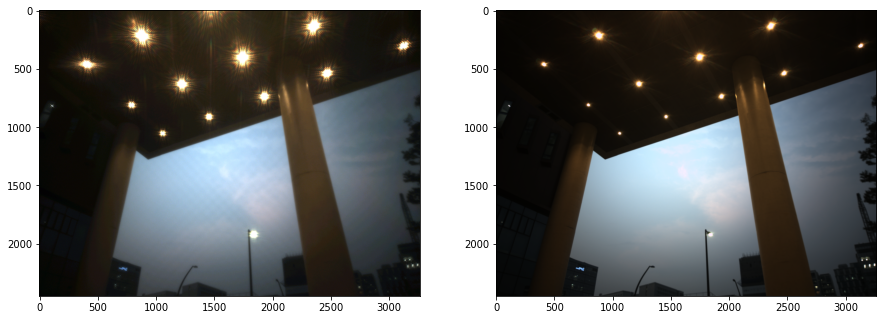

C:/Users/User/Desktop/train_input_img/train_input_10060.png C:/Users/User/Desktop/train_label_img/train_label_10060.png 



In [15]:
import cv2

for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = cv2.imread(input_path)
    targ_img = cv2.imread(label_path)
    plt.figure(figsize=(15,10))
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(inp_img)
    plt.subplot(1,2,2)
    plt.imshow(targ_img)
    plt.show()
    print(input_path, label_path, '\n')
    break
    
#이미지를 확인해 보기위한 코드
#zip은 말그대로 합친다는 뜻
#cv2.imread는 읽기모드로 열기
#cv2.cvtColor는 우리가 아는 빨파초의 색으로 보이도록 해줌
#plt.imshow는 이미지를 보여주는 코드

    


# customdataset 설정

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data, label,w,h ,is_train=True):
        self.data  = data
        self.label = label
        self.w = w
        self.h = h
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, image, label):
        
        resizer = transforms.Resize(size=(self.h, self.w))
        image = resizer(image)
        label = resizer(label)

        image = TF.to_tensor(image)
        label = TF.to_tensor(label)
        return image, label
    
    def __getitem__(self, idx):
        origin_img = Image.open(self.data[idx])
        label_img  = Image.open(self.label[idx])
        
        origin_img, label_img = self.transform(origin_img, label_img)
        return origin_img, label_img
    
#def __init__는 생성자
#def __len__은 데이셋의 길이를 변환
#def __transform 에서 resize = 이미지 크기 재지정 , to_tensor = 이미지를 tensor형으로 변경
#def __getitem__은 이미지를 호출하고 transform함수를 적용 시킨 후 이미지를 호출

In [17]:
class testDataset(Dataset):
    def __init__(self, data,is_train=True):
        self.data  = data
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, image):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((384, 512))
        ])
        image = transform(image)
        
        return image
    
    def __getitem__(self, idx):
        origin_img = Image.open(self.data[idx])
        
        origin_img = self.transform(origin_img)
        return origin_img
    
#위에 코드랑 동일 하지만 test image는 label이 없기 때문에 data에 대한 작업만을 수행

In [18]:
train_dataset = CustomDataset(train_input_files, train_label_files,512,384)
vaild_dataset = CustomDataset(vaild_input_files, vaild_label_files,512,384)
test_dataset = testDataset(test_all_input_files)

#dataset(학습을 시킬 때 문제-답의 형식으로 이루어진 dataset을 가지고 문제에 대한 예상 값을 내면 그 예상과 답 사이의 간격을
#줄여나가는 방식이다.) dataset이라는 것은 (문제,답)으로 이루어진 문제집

In [19]:
print(len(train_dataset))

562


In [20]:
print(len(vaild_dataset))

60


In [21]:
print(len(test_dataset))

20


In [22]:
train_dataset[0][0].shape

torch.Size([3, 384, 512])

In [23]:
vaild_dataset[0][0].shape

torch.Size([3, 384, 512])

In [24]:
test_dataset[0].shape

torch.Size([3, 384, 512])

In [25]:
train_loader = DataLoader(train_dataset , batch_size = 4, shuffle = False)
vaild_loader = DataLoader(vaild_dataset , batch_size = 4, shuffle = False)
test_loader = DataLoader(test_dataset , batch_size = 1 , shuffle = False )

#DataLoader는 dataset을 불러오는 과정인데 batch_size = 4는 dataset에서 이미지를 4개씩 묶어서 가져온다는 것을 의미한다
#shffile은 우리가 사용하는 662개의 데이터를 순차적으로 가져올 것인지 임의로 4개를 가져올 것인지 결정)

In [26]:
print(len(train_loader))

141


In [27]:
print(len(vaild_loader))

15


In [28]:
print(len(test_loader))

20


# model

In [29]:
'''
model = smp.UnetPlusPlus(encoder_name='resnet18',
                encoder_weights='imagenet',
                in_channels=3, classes=3, activation='sigmoid')
                '''

"\nmodel = smp.UnetPlusPlus(encoder_name='resnet18',\n                encoder_weights='imagenet',\n                in_channels=3, classes=3, activation='sigmoid')\n                "

In [30]:
'''
model = smp.UnetPlusPlus(encoder_name='efficientnet-b4',
                encoder_weights='imagenet',
                in_channels=3, classes=3, activation='sigmoid')
                '''
                

"\nmodel = smp.UnetPlusPlus(encoder_name='efficientnet-b4',\n                encoder_weights='imagenet',\n                in_channels=3, classes=3, activation='sigmoid')\n                "

In [31]:

model = smp.UnetPlusPlus(encoder_name='mobilenet_v2',
                encoder_weights='imagenet',
                in_channels=3, classes=3, activation='sigmoid')
#이건 너무 복잡하니 일단 생략

In [32]:
model.to(device)
model
#모델이 어떻게 구성되어 있는지 출력

UnetPlusPlus(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), b

# train

In [33]:
criterion = torch.nn.MSELoss().to(device) #예상 답과 실제 답의 차이를 줄이기 위한 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #가중치를 갱신해주는 함수
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 10, gamma=0.8)#학습에 사용 되는 가중치를 조절해주는 함수

In [34]:
train_loss = []
vaild_loss=[]
for epoch in range(100):
    total_loss = 0
    model.train()
    
    for image , label in tqdm(train_loader,total=len(train_loader),leave = False):
        image = image.to(device)
        label = label.to(device)
        output = model(image.float())
        loss = torch.sqrt(criterion(output,label))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss.append(total_loss/len(train_loader))
    print("epoch :" , epoch+1 , "loss :" , total_loss/len(train_loader))
    
    scheduler.step()
    
    idx = 1
    
    model.eval()
    with torch.no_grad():
        for image , label in tqdm(vaild_loader,total=len(vaild_loader),leave = False):
            image = image.to(device)
            label = label.to(device)
            output = model(image.float())
            loss = torch.sqrt(criterion(output,label))
            
            total_loss += loss.item()
            

            target_path = 'E:/custom_unet/' + str(epoch+1)+'/'
            if not os.path.exists(target_path):
                os.makedirs(target_path, exist_ok=True)

            grid = torchvision.utils.make_grid(tensor=torch.vstack([image,label,output]), nrow=image.shape[0])    # Saving results
            torchvision.utils.save_image(grid, target_path+str(idx)+'.png')
            idx +=1
        vaild_loss.append(total_loss/len(vaild_loader))
        print("val_epoch :" , epoch+1 , "val_loss :" , total_loss/len(vaild_loader))
    

#요약으로 dataset에서 문제(image)와 답지(label)을 호출 하고 model에 문제를 넣음(output = modle(image))
#output은 예상 답을 의미 하고 loss변수는 예상 답과 실제 답에 대한 차이를 줄여 나감
#zero_grad는 가중치를 초기화해주는 함수
#loss backward는 역전파 알고리즘에 대한 것으로 신경망 방향을 순방향으로 한번 역방향으로 한번 확인 후 비교를 하는 것
    

  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 1 loss : 0.15524954967042234


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 1 val_loss : 1.546759415914615


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 2 loss : 0.11715358424376934


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 2 val_loss : 1.182611659169197


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 3 loss : 0.10431652201722699


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 3 val_loss : 1.077023059129715


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 4 loss : 0.0937367577819114


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 4 val_loss : 0.9662360973656178


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 5 loss : 0.08541843229046105


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 5 val_loss : 0.877969013651212


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 6 loss : 0.08100737213877075


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 6 val_loss : 0.8422047073642412


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 7 loss : 0.08082694137561405


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 7 val_loss : 0.846705000847578


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 8 loss : 0.07567043063488413


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 8 val_loss : 0.7919743731617928


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 9 loss : 0.07322685394092654


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 9 val_loss : 0.7626849482456843


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 10 loss : 0.07011111965733217


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 10 val_loss : 0.7316428758203983


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 11 loss : 0.06710511781539477


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 11 val_loss : 0.7200398162007332


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 12 loss : 0.06488758074582046


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 12 val_loss : 0.6870607905089855


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 13 loss : 0.06193442239776148


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 13 val_loss : 0.6663355957716703


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 14 loss : 0.061491656586105094


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 14 val_loss : 0.6555624146014452


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 15 loss : 0.05894477250622519


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 15 val_loss : 0.6544340414305528


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 16 loss : 0.05779519904378458


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 16 val_loss : 0.6325216487050056


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 17 loss : 0.05740439284143718


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 17 val_loss : 0.6403915365537007


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 18 loss : 0.057534072812356


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 18 val_loss : 0.6143552998701731


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 19 loss : 0.05444494234596161


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 19 val_loss : 0.6184375861038764


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 20 loss : 0.05343010433757982


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 20 val_loss : 0.5838510482261579


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 21 loss : 0.052974024761124706


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 21 val_loss : 0.6015172895044089


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 22 loss : 0.05259955745745212


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 22 val_loss : 0.5915653496980667


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 23 loss : 0.05197678057225884


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 23 val_loss : 0.6041152261197567


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 24 loss : 0.05146858381464126


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 24 val_loss : 0.5903755009174347


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 25 loss : 0.05052639549294262


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 25 val_loss : 0.5706303032735983


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 26 loss : 0.048319670034849896


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 26 val_loss : 0.5519170209765434


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 27 loss : 0.04699319701456855


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 27 val_loss : 0.5461244980494181


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 28 loss : 0.0453423687276688


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 28 val_loss : 0.5196745333572229


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 29 loss : 0.047455799891382246


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 29 val_loss : 0.5328877625366052


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 30 loss : 0.047938870807700124


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 30 val_loss : 0.5475720256567002


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 31 loss : 0.04720887477040714


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 31 val_loss : 0.547572577620546


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 32 loss : 0.045748774794504996


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 32 val_loss : 0.5352092361698548


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 33 loss : 0.044774533758032406


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 33 val_loss : 0.527402722214659


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 34 loss : 0.04621593053089389


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 34 val_loss : 0.5296273794025183


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 35 loss : 0.04435941281048118


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 35 val_loss : 0.5283284105360508


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 36 loss : 0.04383613747802186


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 36 val_loss : 0.5150862490137418


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 37 loss : 0.0443708460302429


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 37 val_loss : 0.5090104839454095


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 38 loss : 0.04459153951958139


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 38 val_loss : 0.5027960676699876


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 39 loss : 0.043765231372511135


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 39 val_loss : 0.49620055022339027


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 40 loss : 0.0427751991607196


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 40 val_loss : 0.478577005614837


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 41 loss : 0.04285378304990471


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 41 val_loss : 0.4812427641203006


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 42 loss : 0.04224634276214221


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 42 val_loss : 0.46834788223107654


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 43 loss : 0.04058276872474251


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 43 val_loss : 0.45393398168186344


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 44 loss : 0.040717215085705964


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 44 val_loss : 0.4496310209234556


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 45 loss : 0.04037394082662484


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 45 val_loss : 0.45119856037199496


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 46 loss : 0.040226496227666844


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 46 val_loss : 0.4598169403771559


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 47 loss : 0.03944090823808038


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 47 val_loss : 0.439938364798824


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 48 loss : 0.03908985295722671


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 48 val_loss : 0.4470109837750594


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 49 loss : 0.03829767400438481


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 49 val_loss : 0.4362814839929342


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 50 loss : 0.0380858164544858


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 50 val_loss : 0.42826686886449655


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 51 loss : 0.0389371681958437


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 51 val_loss : 0.4373905923217535


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 52 loss : 0.03855844834119293


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 52 val_loss : 0.43195749980707965


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 53 loss : 0.03778552459486833


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 53 val_loss : 0.4236921936273575


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 54 loss : 0.037748513426235385


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 54 val_loss : 0.4237251814454794


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 55 loss : 0.03726704314298241


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 55 val_loss : 0.4244177511582772


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 56 loss : 0.03635718942956721


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 56 val_loss : 0.4151415226360162


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 57 loss : 0.036196355529605075


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 57 val_loss : 0.408474059527119


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 58 loss : 0.03545482185874002


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 58 val_loss : 0.40303295888006685


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 59 loss : 0.03569169923768822


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 59 val_loss : 0.41724007079998654


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 60 loss : 0.03624419223332236


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 60 val_loss : 0.4104363868633906


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 61 loss : 0.03543851866736902


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 61 val_loss : 0.4089020375162363


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 62 loss : 0.03466880795750635


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 62 val_loss : 0.40218153931200507


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 63 loss : 0.03480911392269405


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 63 val_loss : 0.40126288930575055


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 64 loss : 0.03588051338356438


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 64 val_loss : 0.40742482021451


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 65 loss : 0.034076704346436136


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 65 val_loss : 0.3984630747387807


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 66 loss : 0.0333059086920099


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 66 val_loss : 0.38636557509501773


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 67 loss : 0.03257671002536378


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 67 val_loss : 0.3810783946265777


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 68 loss : 0.03248202584102644


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 68 val_loss : 0.3816757619380951


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 69 loss : 0.03343492816367471


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 69 val_loss : 0.3869903739541769


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 70 loss : 0.0335359458963499


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 70 val_loss : 0.3821029731382926


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 71 loss : 0.034923563215960844


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 71 val_loss : 0.4090005782743295


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 72 loss : 0.03246746633650986


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 72 val_loss : 0.38330638942619166


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 73 loss : 0.031736380823537816


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 73 val_loss : 0.3730440720915794


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 74 loss : 0.03130701148605093


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 74 val_loss : 0.3707339690377315


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 75 loss : 0.032089018533732874


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 75 val_loss : 0.37577099837362765


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 76 loss : 0.03185382147207328


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 76 val_loss : 0.3767552944521109


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 77 loss : 0.030881696030603232


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 77 val_loss : 0.3681146713594596


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 78 loss : 0.030597603225961646


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 78 val_loss : 0.36911498457193376


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 79 loss : 0.030848925140626888


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 79 val_loss : 0.36465249843895436


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 80 loss : 0.030439510347044216


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 80 val_loss : 0.36789801307022574


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 81 loss : 0.031261425901283606


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 81 val_loss : 0.3749503012746572


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 82 loss : 0.030216099416955987


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 82 val_loss : 0.3573394405345122


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 83 loss : 0.02982316164841466


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 83 val_loss : 0.3605749166260163


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 84 loss : 0.029366541046200068


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 84 val_loss : 0.35661911144852637


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 85 loss : 0.02920954756385891


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 85 val_loss : 0.34919316694140434


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 86 loss : 0.029230748679726682


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 86 val_loss : 0.34739081549147766


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 87 loss : 0.029801034745066724


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 87 val_loss : 0.3533779878169298


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 88 loss : 0.030146268784260074


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 88 val_loss : 0.3578549835830927


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 89 loss : 0.03058205297916916


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 89 val_loss : 0.36014014246563114


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 90 loss : 0.029645762782781682


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 90 val_loss : 0.354362050195535


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 91 loss : 0.029306790467800825


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 91 val_loss : 0.3515687675525745


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 92 loss : 0.028688464287325


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 92 val_loss : 0.3476644178231557


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 93 loss : 0.028264900550563285


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 93 val_loss : 0.3486961454153061


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 94 loss : 0.02838297690271486


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 94 val_loss : 0.3457105403145154


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 95 loss : 0.028439234691203064


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 95 val_loss : 0.34765373133122923


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 96 loss : 0.028422917695121563


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 96 val_loss : 0.35343837390343347


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 97 loss : 0.02815602980025694


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 97 val_loss : 0.34215874286989373


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 98 loss : 0.028365238853697235


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 98 val_loss : 0.34470137444635235


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 99 loss : 0.028096415776204555


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 99 val_loss : 0.3450215400507053


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 100 loss : 0.028202422148158365


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 100 val_loss : 0.34015664805968604


# vaild_시각화

In [35]:
results = [y for x in os.walk('E:/custom_unet/100/') for y in glob(os.path.join(x[0], '*.png'))]

In [36]:
width = 384
height = 512

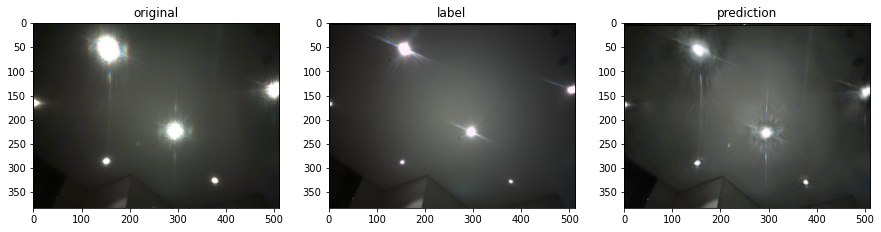

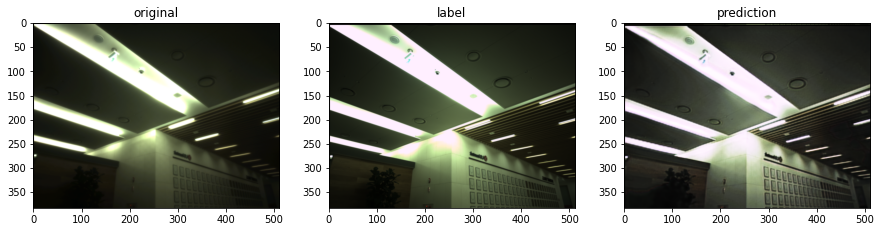

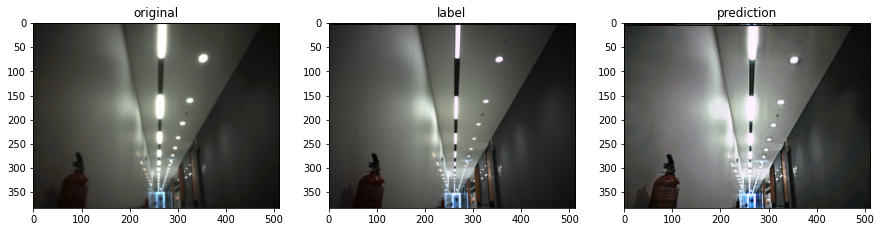

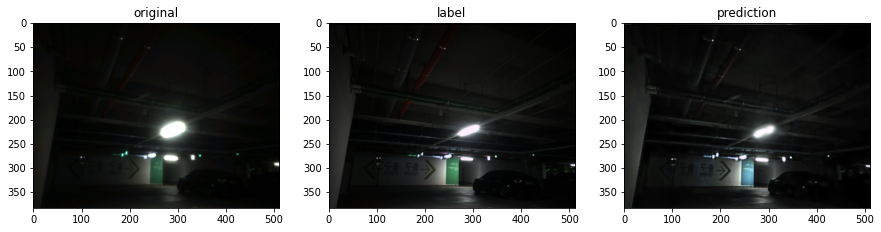

In [37]:
for idx, each_result in enumerate(results):
    if idx % 4 ==0:
        input  = np.array(Image.open(each_result))[:width, :height, :]
        target = np.array(Image.open(each_result))[width*1:width*2, :height, :]
        recon  = np.array(Image.open(each_result))[width*2:width*3, :height, :]
        
 
        _, ax = plt.subplots(1, 3, figsize=(15,15))

        ax[0].set_title('original')
        ax[0].imshow(input)

        ax[1].set_title('label')
        ax[1].imshow(target)

        ax[2].set_title('prediction')
        ax[2].imshow(recon)

        plt.show()

# test image 예측

In [38]:
model.eval()
with torch.no_grad():
    for image  in test_loader:
        image = image
        output = model(image.to(device))    
        
        break

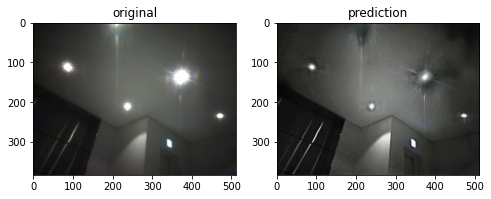

In [39]:
for i in range(1):
    
    fix , ax = plt.subplots(ncols = 2,figsize = (8,8))
    ax[0].set_title('original')
    ax[0].imshow(np.moveaxis(image[i].cpu().numpy(),0,2))
    out = output.detach().cpu()[i]
    ax[1].set_title('prediction')
    ax[1].imshow(np.moveaxis(out.cpu().numpy(),0,2))

In [40]:
torch.save(model.state_dict(), 'E:/model_save/'+'mobilenet.pt')
#model.load_state_dict(torch.load(PATH))

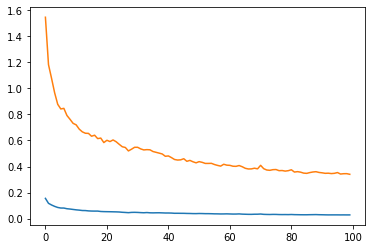

In [41]:
plt.plot(train_loss)
plt.plot(vaild_loss)

In [42]:
def test(model, test_load, model_name):
    model.eval()
    
    with torch.no_grad():
        for num, data in tqdm(enumerate(test_load), total=len(test_load)):
            data = data.to(device)
            
            output = model(data)
            
            out = transforms.transforms.Resize((348, 512))(output)

            torchvision.utils.save_image(out, f'C:/Users/User/Desktop/{model_name}/test_{20000+num}.png')

In [43]:
test(model, test_loader, 'mobilenet')

  0%|          | 0/20 [00:00<?, ?it/s]